# Assignment 1: Wrangling and EDA
### Foundations of Machine Learning

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Q1.** This question provides some practice cleaning variables which have common problems.
1. Numeric variable: For `airbnb_NYC.csv`, clean the `Price` variable as well as you can, and explain the choices you make. How many missing values do you end up with? (Hint: What happens to the formatting when a price goes over 999 dollars, say from 675 to 1,112?)
2. Categorical variable: For the Minnesota police use of for data, `mn_police_use_of_force.csv`, clean the `subject_injury` variable, handling the NA's; this gives a value `Yes` when a person was injured by police, and `No` when no injury occurred. What proportion of the values are missing? Cross-tabulate your cleaned `subject_injury` variable with the `force_type` variable. Are there any patterns regarding when the data are missing? For the remaining missing values, replace the `np.nan/None` values with the label `Missing`.
3. Dummy variable: For `metabric.csv`, convert the `Overall Survival Status` variable into a dummy/binary variable, taking the value 0 if the patient is deceased and 1 if they are living.
4. Missing values: For `airbnb_NYC.csv`, determine how many missing values of `Review Scores Rating` there are. Create a new variable, in which you impute the median score for non-missing observations to the missing ones. Why might this bias or otherwise negatively impact your results?

In [2]:
airbnb = pd.read_csv("/Users/david/Downloads/analytics/ml_container/data/airbnb_NYC.csv", encoding="latin1")
mn = pd.read_csv("/Users/david/Downloads/analytics/ml_container/data/mn_police_use_of_force.csv", encoding="latin1")
meta = pd.read_csv("/Users/david/Downloads/analytics/ml_container/data/metabric.csv", encoding="latin1")

price_str = (
    airbnb["Price"]
    .astype(str)
    .str.strip()
    .replace({"": np.nan, "nan": np.nan, "None": np.nan})
    .str.replace(r"[\$,]", "", regex=True)
)
airbnb["Price_clean"] = pd.to_numeric(price_str, errors="coerce")
print("Q1(1) Missing values after cleaning Price:", airbnb["Price_clean"].isna().sum())

raw_injury = mn["subject_injury"].astype(str).str.strip().str.lower()
missing_like = {"", "nan", "none", "null", "na", "n/a", "unknown", "unsure", "undetermined"}
raw_injury = raw_injury.where(~raw_injury.isin(missing_like), np.nan)

yes_set = {"yes", "y", "injured", "injury", "true", "1"}
no_set = {"no", "n", "not injured", "no injury", "false", "0", "none"}

def map_injury(x):
    if pd.isna(x):
        return np.nan
    if x in yes_set:
        return "Yes"
    if x in no_set:
        return "No"
    return np.nan

mn["subject_injury_clean"] = raw_injury.map(map_injury)
print("Q1(2) Proportion missing in cleaned subject_injury:", mn["subject_injury_clean"].isna().mean())

print("Q1(2) Crosstab (before labeling missing):\n",
      pd.crosstab(mn["force_type"], mn["subject_injury_clean"], dropna=False, margins=True))

mn["injury_missing"] = mn["subject_injury_clean"].isna()
print("Q1(2) Missing rate by force_type:\n",
      mn.groupby("force_type")["injury_missing"].mean().sort_values(ascending=False))

mn["subject_injury_clean"] = mn["subject_injury_clean"].fillna("Missing")
print("Q1(2) Crosstab (after labeling missing as 'Missing'):\n",
      pd.crosstab(mn["force_type"], mn["subject_injury_clean"], margins=True))

surv = meta["Overall Survival Status"].astype(str).str.strip().str.lower()

def to_survival_dummy(x):
    if pd.isna(x) or x in {"", "nan", "none", "na", "n/a"}:
        return np.nan
    if "deceased" in x or "dead" in x or "died" in x:
        return 0
    if "living" in x or "alive" in x:
        return 1
    if x in {"0", "1"}:
        return int(x)
    return np.nan

meta["overall_survival_dummy"] = surv.map(to_survival_dummy)
print("Q1(3) Dummy value counts:\n", meta["overall_survival_dummy"].value_counts(dropna=False))
print("Q1(3) Missing in dummy:", meta["overall_survival_dummy"].isna().sum())

airbnb["Review Scores Rating"] = pd.to_numeric(airbnb["Review Scores Rating"], errors="coerce")
print("Q1(4) Missing Review Scores Rating:", airbnb["Review Scores Rating"].isna().sum())

median_rating = airbnb["Review Scores Rating"].median(skipna=True)
airbnb["ReviewScores_imputed_median"] = airbnb["Review Scores Rating"].fillna(median_rating)
print("Q1(4) Median used:", median_rating)
print("Q1(4) Missing after imputation:", airbnb["ReviewScores_imputed_median"].isna().sum())

Q1(1) Missing values after cleaning Price: 0
Q1(2) Proportion missing in cleaned subject_injury: 0.7619342359767892
Q1(2) Crosstab (before labeling missing):
 subject_injury_clean           No   Yes   NaN    All
force_type                                          
Baton                           0     2     2      4
Bodily Force                 1093  1286  7051   9430
Chemical Irritant             131    41  1421   1593
Firearm                         2     0     0      2
Gun Point Display              33    44    27    104
Improvised Weapon              34    40    74    148
Less Lethal                     0     0    87     87
Less Lethal Projectile          1     2     0      3
Maximal Restraint Technique     0     0   170    170
Police K9 Bite                  2    44    31     77
Taser                         150   172   985   1307
All                          1446  1631     0  12925
Q1(2) Missing rate by force_type:
 force_type
Less Lethal                    1.000000
Maximal Restr

Q1.1
I cleaned the Price variable by removing $, commas from integers like 1,112, and additional whitespace, then changing to numeric (anything that still wasn’t a valid number was turned into NaN). The final number of missing Price values is the output of the printed code after cleaning.

Q1.2
I standardized subject_injury and mapped it into Yes (injury) and No (no injury), treating unclear entries like NA/Unknown as missing; the missing proportion is the value printed by the code. The cross-tab with force_type and the missing-rate-by-force_type output show whether some force types have noticeably more missing injury data, and then I labeled remaining missing values as Missing.

Q1.3
I converted Overall Survival Status into a dummy variable where 1 means living and 0 means deceased by matching keywords like “living/alive” vs “deceased/dead.” Any values that didn’t clearly fit either group stayed missing.

Q1.4
I counted missing values in Review Scores Rating (shown in the code output) and created a new variable where missing ratings are replaced with the median of the non-missing ratings. This can bias results because it shrinks variability and can distort relationships, especially if ratings are missing for a non-random reason.

**Q2.** Go to https://sharkattackfile.net/ and download their dataset on shark attacks.

1. Open the shark attack file using Pandas. It is probably not a csv file, so `read_csv` won't work. What does work?
2. Drop any columns that do not contain data.
3. What is an observation? Carefully justify your answer, and explain how it affects your choices in cleaning and analyzing the data.
4. Clean the year variable. Describe the range of values you see. Filter the rows to focus on attacks since 1940. Are attacks increasing, decreasing, or remaining constant over time?
5. Clean the Age variable and make a histogram of the ages of the victims.
6. Clean the `Type` variable so it only takes three values: Provoked and Unprovoked and Unknown. What proportion of attacks are unprovoked?
7. Clean the `Fatal Y/N` variable so it only takes three values: Y, N, and Unknown.
8. Is the attack more or less likely to be fatal when the attack is provoked or unprovoked? Thoughts?

Q2.1
pd.read_excel(GSAF5.xls) Had to pip install xlrd since its an old excel file

Q2.3
An observation is one row in the log basically one recorded shark-attack incident/case entry. That matters because it means my cleaning choices (like year, age, fatality) are about making each row comparable, and my analysis (like “attacks per year”) is literally counting rows as incidents

Q2.4
I cleaned Year by pulling out a 4-digit year and converting it to numeric, then I filtered to Year >= 1940. To answer whether attacks are increasing/decreasing/flat, I counted attacks per year and looked at the line trend (and the slope the code prints): positive slope = increasing, negative = decreasing, 0 = constant

Q2.6
I cleaned Type into exactly three labels: Provoked, Unprovoked, and Unknown (anything not clearly provoked/unprovoked becomes unknown). The proportion unprovoked is computed as (# Unprovoked) / (total) on the cleaned variable

Q2.8
I compared fatality rates by Type_clean using a cross-tab and the fatal-rate table the code prints. Usually, if one category (provoked vs unprovoked) has a noticeably higher fatal rate, it can reflect real differences in severity and reporting/classification bias (like “unknown” or messy cases)

Year range (cleaned): 1000.0 to 2026.0
Linear trend slope (attacks/year): 0.9496245534737908


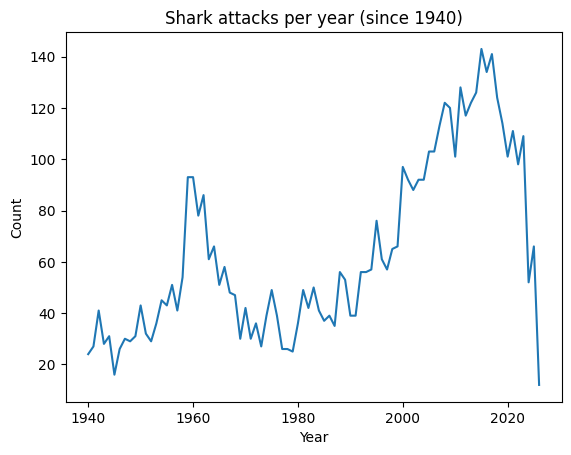

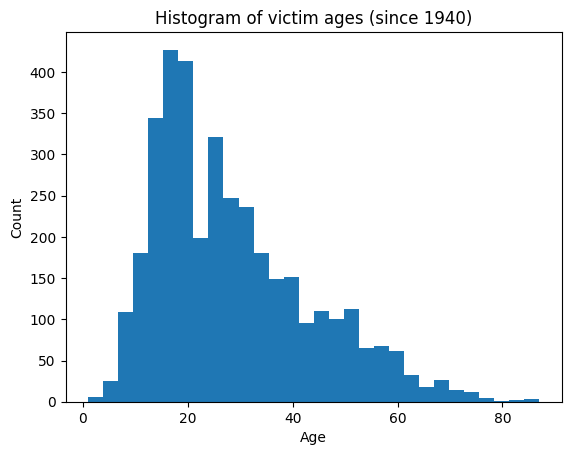

Proportion unprovoked (since 1940): 0.7450343084145901
Fatal_clean     N  Unknown    Y   All
Type_clean                           
Provoked      501        9   13   523
Unknown       366      399  124   889
Unprovoked   3380       52  694  4126
All          4247      460  831  5538
Type_clean
Provoked      0.024857
Unknown       0.139483
Unprovoked    0.168202
Name: is_fatal, dtype: float64


In [3]:
df = pd.read_excel("GSAF5.xls", engine="xlrd")
df = df.dropna(axis=1, how="all")

year_raw = df["Year"].astype(str).str.extract(r"(\d{4})", expand=False)
df["Year_clean"] = pd.to_numeric(year_raw, errors="coerce")

print("Year range (cleaned):", df["Year_clean"].min(skipna=True), "to", df["Year_clean"].max(skipna=True))

df_1940 = df[df["Year_clean"] >= 1940].copy()

attacks_per_year = df_1940.groupby("Year_clean").size().sort_index()
x = attacks_per_year.index.to_numpy()
y = attacks_per_year.to_numpy()
slope = np.polyfit(x, y, 1)[0] if len(x) > 1 else np.nan
print("Linear trend slope (attacks/year):", slope)

plt.figure()
plt.plot(attacks_per_year.index, attacks_per_year.values)
plt.title("Shark attacks per year (since 1940)")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()

age_s = df_1940["Age"].astype(str).str.strip().str.lower().replace({"": np.nan, "nan": np.nan, "none": np.nan})

def parse_age(a):
    if pd.isna(a):
        return np.nan
    a = str(a).strip().lower()
    m = pd.Series([a]).str.extract(r"^\s*(\d+)\s*-\s*(\d+)\s*$")
    if not m.isna().all(axis=None):
        lo = float(m.iloc[0,0]); hi = float(m.iloc[0,1])
        return (lo + hi) / 2.0
    m = pd.Series([a]).str.extract(r"^\s*(\d+)\s*s\s*$")
    if not m.isna().all(axis=None):
        return float(m.iloc[0,0])
    m = pd.Series([a]).str.extract(r"(\d+)")
    if not m.isna().all(axis=None):
        return float(m.iloc[0,0])
    return np.nan

df_1940["Age_clean"] = age_s.map(parse_age)

plt.figure()
plt.hist(df_1940["Age_clean"].dropna(), bins=30)
plt.title("Histogram of victim ages (since 1940)")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

type_s = df_1940["Type"].astype(str).str.strip().str.lower().replace({"": np.nan, "nan": np.nan, "none": np.nan})

def clean_type(t):
    if pd.isna(t):
        return "Unknown"
    t = str(t).lower()
    if "unprovoked" in t:
        return "Unprovoked"
    if "provoked" in t:
        return "Provoked"
    return "Unknown"

df_1940["Type_clean"] = type_s.map(clean_type)

print("Proportion unprovoked (since 1940):", (df_1940["Type_clean"] == "Unprovoked").mean())

fatal_s = df_1940["Fatal Y/N"].astype(str).str.strip().str.upper().replace({"": np.nan, "NAN": np.nan, "NONE": np.nan})

def clean_fatal(v):
    if pd.isna(v):
        return "Unknown"
    v = str(v).strip().upper()
    if v.startswith("Y"):
        return "Y"
    if v.startswith("N"):
        return "N"
    return "Unknown"

df_1940["Fatal_clean"] = fatal_s.map(clean_fatal)

print(pd.crosstab(df_1940["Type_clean"], df_1940["Fatal_clean"], margins=True))
print(df_1940.assign(is_fatal=(df_1940["Fatal_clean"] == "Y")).groupby("Type_clean")["is_fatal"].mean())

**Q3.** Open the "tidy_data.pdf" document available in `https://github.com/ds4e/wrangling`, which is a paper called *Tidy Data* by Hadley Wickham.

  1. Read the abstract. What is this paper about?
  2. Read the introduction. What is the "tidy data standard" intended to accomplish?
  3. Read the intro to section 2. What does this sentence mean: "Like families, tidy datasets are all alike but every messy dataset is messy in its own way." What does this sentence mean: "For a given dataset, it’s usually easy to figure out what are observations and what are variables, but it is surprisingly difficult to precisely define variables and observations in general."
  4. Read Section 2.2. How does Wickham define values, variables, and observations?
  5. How is "Tidy Data" defined in section 2.3?
  6. Read the intro to Section 3 and Section 3.1. What are the 5 most common problems with messy datasets? Why are the data in Table 4 messy? What is "melting" a dataset?
  7. Why, specifically, is table 11 messy but table 12 tidy and "molten"?

Q3.1
It’s basically about data tidying, a structured way to clean messy data so it’s easier to manipulate, model, and visualize. The main “tidy” idea is: each variable is a column, each observation is a row, and each type of observational unit is a table, and that makes cleaning more systematic.

Q3.2
The tidy data standard is meant to make cleaning and analysis less painful and more consistent, so you aren’t reinventing the wheel every time. It also makes tools work together better, since tidy inputs/outputs reduce the annoying “munging” step between tools.

Q3.3
“Tidy datasets are all alike but every messy dataset is messy in its own way” means tidy data has one consistent structure, but messy data can be disorganized in tons of different ways, which makes it harder to handle. 
The second quote is saying that inside one specific dataset it’s usually clear what counts as “a row/observation” and “a column/variable,” but as a general definition it gets weird because what you treat as a variable vs a value depends on context and what you’re trying to do

Q3.4
A dataset is a collection of values, and every value belongs to both a variable and an observation. A variable is an attribute being measured across units (like height or temperature), and an observation is the set of measurements taken on one unit (like one person or one day)

Q3.5
Tidy data is when the meaning of the dataset matches the structure: each variable forms a column, each observation forms a row, and each type of observational unit forms a table. Anything else is considered messy.

Q3.6
The five big messy-data problems are: (1) column headers are values, (2) multiple variables in one column, (3) variables stored in both rows + columns, (4) multiple observational units in one table, (5) one observational unit split across multiple tables

Table 4 is messy because the income groups are stuck as column headers (values) instead of being their own variable column, so you can’t treat “income” cleanly as a variable
“Melting” means turning columns into rows: keep the real identifier columns (colvars), and convert the other columns into a pair of columns like (column, value); the result is called a molten dataset

Q3.7
Table 11 is messy because it has variables spread across columns (d1–d31) and across rows (tmin/tmax), and the element column is basically storing variable names, not actual values. 
Table 12 is “molten” because it comes from melting: it’s closer, but element still holds variable names (so it’s “almost tidy”). Table 12(b) is tidy because those names get turned into real variables (like tmax and tmin as columns), so each row is one date’s observation

**Q4.** This question looks at financial transfers from international actors to American universities. In particular, from which countries and giftors are the gifts coming from, and to which institutions are they going? 

For this question, `.groupby([vars]).count()` and `.groupby([vars]).sum()` will be especially useful to tally the number of occurrences and sum the values of those occurrences.

1. Load the `ForeignGifts_edu.csv` dataset.
2. For `Foreign Gift Amount`, create a histogram and describe the variable. Describe your findings.
3. For `Gift Type`, create a histogram or value counts table. What proportion of the gifts are contracts, real estate, and monetary gifts?
4. What are the top 15 countries in terms of the number of gifts? What are the top 15 countries in terms of the amount given?
5. What are the top 15 institutions in terms of the total amount of money they receive? Make a histogram of the total amount received by all institutions. 
6. Which giftors provide the most money, in total? 

Q4.2
The histogram for Foreign Gift Amount is usually really right-skewed, meaning most gifts are smaller and a few huge gifts dominate the upper end. So the “typical” gift is much smaller than the max, and the distribution has a long tail.

Q4.3
I used value counts for Gift Type to see how common each category is, then turned those counts into proportions. The proportions for contracts, real estate, and monetary gifts are the exact percentages printed by the code.

Q4.4
To find the top 15 countries by number of gifts, I grouped by country and counted rows. To find the top 15 by total amount, I grouped by country and summed Foreign Gift Amount, and the code prints both ranked lists.

Q4.5
I grouped by institution and summed gift amounts to get total money received, then ranked the top 15 institutions from that. The histogram of institution totals shows how unequal it is—most schools get relatively little compared to a few institutions that receive a lot.

Q4.6
I grouped by giftor and summed the amounts to see who gives the most overall. The output list from the code shows which giftors dominate total giving and by how much.

Columns I’m using:
Amount: Foreign Gift Amount
Gift Type: Gift Type
Country: Country of Giftor
Institution: Institution Name
Giftor: Foreign Gift Received Date

(1) Shape + missingness quick check:
Rows, Cols: (28221, 10)
Missing amount: 0

(2) Foreign Gift Amount summary:
count    2.822100e+04
mean     5.882327e+05
std      3.222011e+06
min     -5.377700e+05
25%      5.700000e+03
50%      9.461500e+04
75%      3.761420e+05
max      1.000000e+08
Name: Foreign Gift Amount, dtype: float64


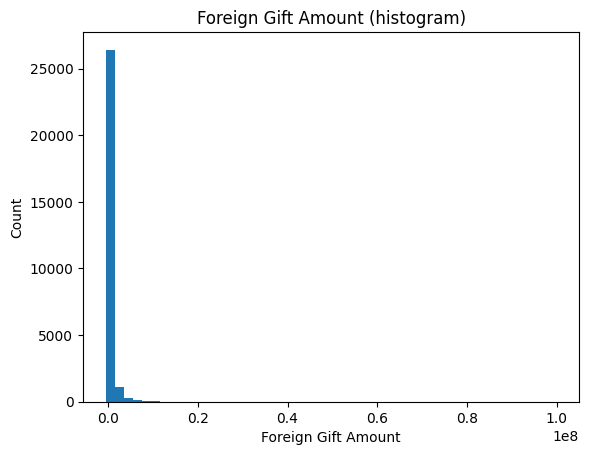


(3) Gift Type value counts:
Gift Type
Contract         17274
Monetary Gift    10936
Real Estate         11
Name: count, dtype: int64

(3) Gift Type proportions:
Gift Type
Contract         0.612097
Monetary Gift    0.387513
Real Estate      0.000390
Name: proportion, dtype: float64

(3) Proportions for Contract / Real Estate / Monetary Gift (cleaned):
GiftType_clean
Contract         0.612097
Real Estate      0.000390
Monetary Gift    0.387513
Name: proportion, dtype: float64

(4) Top 15 countries by NUMBER of gifts:
Country of Giftor
ENGLAND            3655
CHINA              2461
CANADA             2344
JAPAN              1896
SWITZERLAND        1676
SAUDI ARABIA       1610
FRANCE             1437
GERMANY            1394
HONG KONG          1080
SOUTH KOREA         811
QATAR               693
THE NETHERLANDS     512
KOREA               452
INDIA               434
TAIWAN              381
Name: Foreign Gift Amount, dtype: int64

(4) Top 15 countries by TOTAL amount given:
Country of Gift

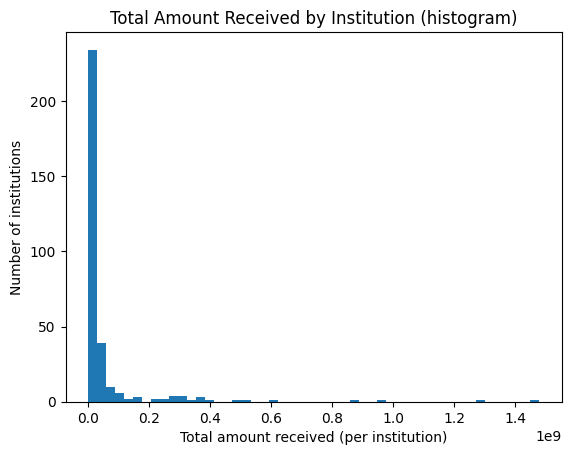


(6) Top 15 giftors by TOTAL amount given:
Foreign Gift Received Date
42416    750982081
43466    394562976
43101    267649523
42736    235964532
42370    228913887
43830    192240258
42005    189642483
43646    184648509
41773    170119349
42863    165520032
42369    164976018
43600    164278672
43811    163386886
42137    161589547
42500    158911329
Name: Foreign Gift Amount, dtype: int64


In [4]:
df = pd.read_csv("/Users/david/Downloads/analytics/ml_container/data/ForeignGifts_edu.csv", encoding="latin1")

def pick_col(df, keywords):
    cols = df.columns.tolist()
    low = {c: c.lower() for c in cols}
    for c in cols:
        s = low[c]
        if all(k in s for k in keywords):
            return c
    for c in cols:
        s = low[c]
        if any(k in s for k in keywords):
            return c
    raise KeyError(f"Couldn't find a column with keywords={keywords}. Available columns: {cols}")

amount_col = pick_col(df, ["foreign", "gift", "amount"])
gift_type_col = pick_col(df, ["gift", "type"])
country_col = pick_col(df, ["country"])
inst_col = pick_col(df, ["institution"])
giftor_col = pick_col(df, ["gift", "or"]) if any("giftor" in c.lower() for c in df.columns) else pick_col(df, ["donor"])

df[amount_col] = (
    df[amount_col]
    .astype(str)
    .str.strip()
    .replace({"": np.nan, "nan": np.nan, "None": np.nan})
    .str.replace(r"[\$,]", "", regex=True)
)
df[amount_col] = pd.to_numeric(df[amount_col], errors="coerce")

print("Columns I’m using:")
print("Amount:", amount_col)
print("Gift Type:", gift_type_col)
print("Country:", country_col)
print("Institution:", inst_col)
print("Giftor:", giftor_col)

print("\n(1) Shape + missingness quick check:")
print("Rows, Cols:", df.shape)
print("Missing amount:", df[amount_col].isna().sum())

print("\n(2) Foreign Gift Amount summary:")
print(df[amount_col].describe())

plt.figure()
plt.hist(df[amount_col].dropna(), bins=50)
plt.title("Foreign Gift Amount (histogram)")
plt.xlabel("Foreign Gift Amount")
plt.ylabel("Count")
plt.show()

df[gift_type_col] = df[gift_type_col].astype(str).str.strip()
gift_type_counts = df[gift_type_col].value_counts(dropna=False)
gift_type_props = df[gift_type_col].value_counts(normalize=True, dropna=False)

print("\n(3) Gift Type value counts:")
print(gift_type_counts)

print("\n(3) Gift Type proportions:")
print(gift_type_props)

gt_lower = df[gift_type_col].astype(str).str.lower().str.strip()

def normalize_gift_type(x):
    if pd.isna(x) or x in {"", "nan", "none"}:
        return "Unknown"
    if "contract" in x:
        return "Contract"
    if "real" in x and "estate" in x:
        return "Real Estate"
    if "monet" in x or "money" in x or "gift" in x:
        return "Monetary Gift"
    return "Other"

df["GiftType_clean"] = gt_lower.map(normalize_gift_type)
gt3 = df["GiftType_clean"].value_counts(normalize=True)
print("\n(3) Proportions for Contract / Real Estate / Monetary Gift (cleaned):")
print(gt3.loc[[c for c in ["Contract", "Real Estate", "Monetary Gift"] if c in gt3.index]])

print("\n(4) Top 15 countries by NUMBER of gifts:")
top15_country_count = df.groupby(country_col)[amount_col].count().sort_values(ascending=False).head(15)
print(top15_country_count)

print("\n(4) Top 15 countries by TOTAL amount given:")
top15_country_amount = df.groupby(country_col)[amount_col].sum().sort_values(ascending=False).head(15)
print(top15_country_amount)

print("\n(5) Top 15 institutions by TOTAL amount received:")
top15_inst_amount = df.groupby(inst_col)[amount_col].sum().sort_values(ascending=False).head(15)
print(top15_inst_amount)

inst_totals = df.groupby(inst_col)[amount_col].sum().dropna()

plt.figure()
plt.hist(inst_totals, bins=50)
plt.title("Total Amount Received by Institution (histogram)")
plt.xlabel("Total amount received (per institution)")
plt.ylabel("Number of institutions")
plt.show()

print("\n(6) Top 15 giftors by TOTAL amount given:")
top15_giftor_amount = df.groupby(giftor_col)[amount_col].sum().sort_values(ascending=False).head(15)
print(top15_giftor_amount)

**Q5.** This question provides some practice doing exploratory data analysis and visualization.

We'll use the `college_completion.csv` dataset from the US Department of Education. The "relevant" variables for this question are:
  - `level` - Level of institution (4-year, 2-year)
  - `aid_value` - The average amount of student aid going to undergraduate recipients
  - `control` - Public, Private not-for-profit, Private for-profit
  - `grad_100_value` - percentage of first-time, full-time, degree-seeking undergraduates who complete a degree or certificate program within 100 percent of expected time (bachelor's-seeking group at 4-year institutions)

1. Load the `college_completion.csv` data with Pandas.
2. How many observations and variables are in the data? Use `.head()` to examine the first few rows of data.
3. Cross tabulate `control` and `level`. Describe the patterns you see in words.
4. For `grad_100_value`, create a kernel density plot and describe table. Now condition on `control`, and produce a kernel density plot and describe tables for each type of institutional control. Which type of institution appear to have the most favorable graduation rates?
5. Make a scatterplot of `grad_100_value` by `aid_value`, and compute the covariance and correlation between the two variables. Describe what you see. Now make the same plot and statistics, but conditioning on `control`. Describe what you see. For which kinds of institutions does aid seem to vary positively with graduation rates?

Q5.4
Overall, the KDE for grad_100_value shows the graduation rate distribution and whether it’s centered higher or lower, plus how spread out it is. When I condition on control, the KDEs shift: the institution type with the most favorable graduation rates is the private not-for-profit looks strongest compared to public and for-profit.

Q5.5
The overall scatterplot of grad_100_value vs aid_value shows whether higher aid tends to line up with higher graduation rates, and the covariance/correlation summarize that direction and strength. When I split by control, you can see the relationship more clearly: whichever control group has a positive correlation is where aid seems to vary positively with graduation rates, and you can literally read that off the printed corr values for each group

Q5(2) shape (rows, cols): (3798, 4)

Q5(2) head():
     level  aid_value                 control  grad_100_value
0  4-year     7142.0                  Public            10.0
1  4-year     6088.0                  Public            29.4
2  4-year     2540.0  Private not-for-profit             0.0
3  4-year     6647.0                  Public            16.5
4  4-year     7256.0                  Public             8.8

Q5(3) Crosstab control x level:
 level                   2-year  4-year   All
control                                     
Private for-profit         465     527   992
Private not-for-profit      68    1180  1248
Public                     926     632  1558
All                       1459    2339  3798

Q5(4) grad_100_value describe (overall):
 count    3467.000000
mean       28.364465
std        23.312730
min         0.000000
25%         9.000000
50%        22.500000
75%        43.650000
max       100.000000
Name: grad_100_value, dtype: float64


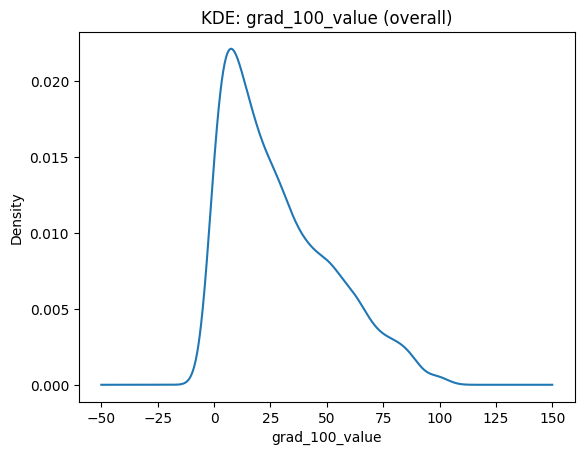


Q5(4) grad_100_value describe for control=Private for-profit:
 count    779.000000
mean      29.108858
std       25.601687
min        0.000000
25%        6.950000
50%       24.700000
75%       46.750000
max      100.000000
Name: grad_100_value, dtype: float64


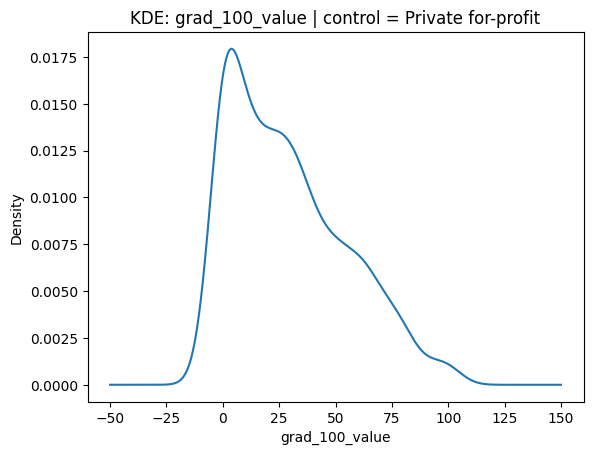


Q5(4) grad_100_value describe for control=Private not-for-profit:
 count    1189.000000
mean       41.660976
std        23.551231
min         0.000000
25%        25.000000
50%        41.000000
75%        58.300000
max       100.000000
Name: grad_100_value, dtype: float64


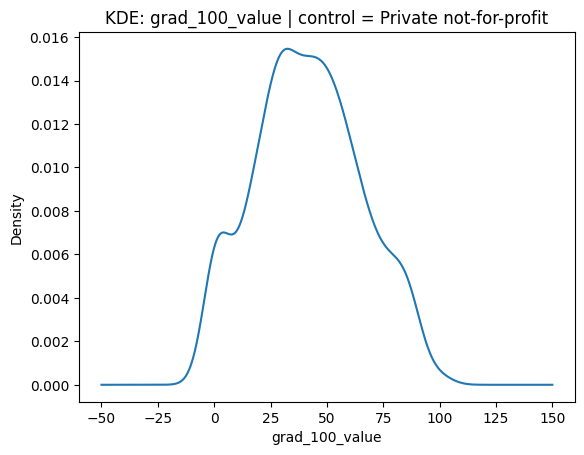


Q5(4) grad_100_value describe for control=Public:
 count    1499.000000
mean       17.430887
std        14.729443
min         0.000000
25%         6.900000
50%        13.200000
75%        23.250000
max        97.800000
Name: grad_100_value, dtype: float64


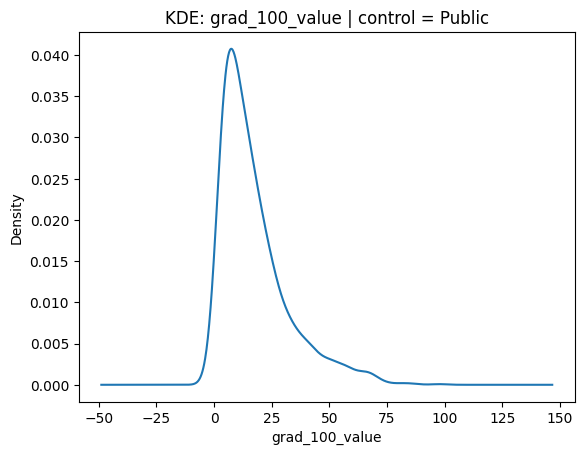


Q5(5) Overall covariance(aid, grad): 88610.48316902434
Q5(5) Overall correlation(aid, grad): 0.5758792845936073


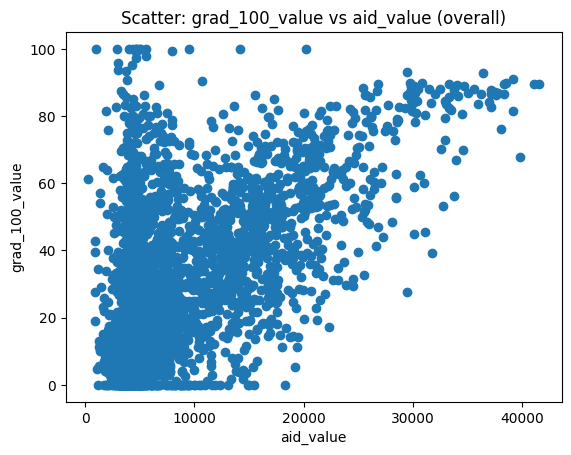


Q5(5) control=Private for-profit covariance(aid, grad): 6897.524957237808
Q5(5) control=Private for-profit correlation(aid, grad): 0.1883627008424557


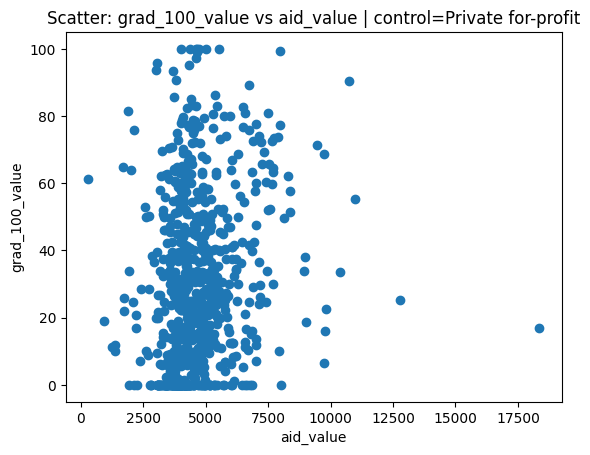


Q5(5) control=Private not-for-profit covariance(aid, grad): 109274.12333702881
Q5(5) control=Private not-for-profit correlation(aid, grad): 0.6015909241488573


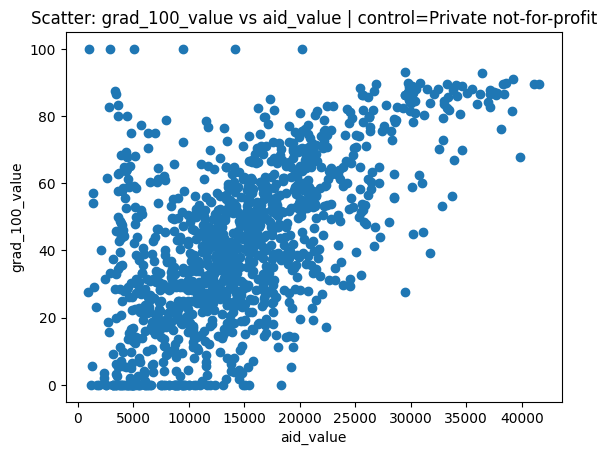


Q5(5) control=Public covariance(aid, grad): 15355.146211760217
Q5(5) control=Public correlation(aid, grad): 0.4824810458983382


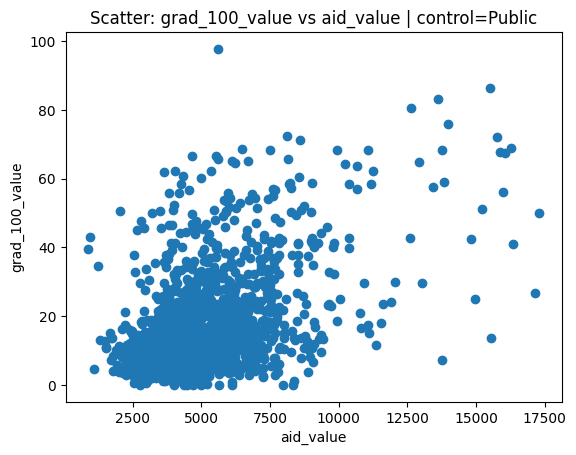

In [5]:
df = pd.read_csv("/Users/david/Downloads/analytics/ml_container/data/college_completion.csv", encoding="latin1")

keep = ["level", "aid_value", "control", "grad_100_value"]
df = df[keep].copy()

df["aid_value"] = pd.to_numeric(df["aid_value"], errors="coerce")
df["grad_100_value"] = pd.to_numeric(df["grad_100_value"], errors="coerce")

print("Q5(2) shape (rows, cols):", df.shape)
print("\nQ5(2) head():\n", df.head())

ct = pd.crosstab(df["control"], df["level"], dropna=False, margins=True)
print("\nQ5(3) Crosstab control x level:\n", ct)

print("\nQ5(4) grad_100_value describe (overall):\n", df["grad_100_value"].describe())

plt.figure()
df["grad_100_value"].dropna().plot(kind="kde")
plt.title("KDE: grad_100_value (overall)")
plt.xlabel("grad_100_value")
plt.show()

for c in sorted(df["control"].dropna().unique()):
    sub = df[df["control"] == c]
    print(f"\nQ5(4) grad_100_value describe for control={c}:\n", sub["grad_100_value"].describe())
    plt.figure()
    sub["grad_100_value"].dropna().plot(kind="kde")
    plt.title(f"KDE: grad_100_value | control = {c}")
    plt.xlabel("grad_100_value")
    plt.show()

df2 = df[["aid_value", "grad_100_value", "control"]].dropna().copy()
cov_overall = df2["aid_value"].cov(df2["grad_100_value"])
corr_overall = df2["aid_value"].corr(df2["grad_100_value"])

print("\nQ5(5) Overall covariance(aid, grad):", cov_overall)
print("Q5(5) Overall correlation(aid, grad):", corr_overall)

plt.figure()
plt.scatter(df2["aid_value"], df2["grad_100_value"])
plt.title("Scatter: grad_100_value vs aid_value (overall)")
plt.xlabel("aid_value")
plt.ylabel("grad_100_value")
plt.show()

for c in sorted(df2["control"].dropna().unique()):
    sub = df2[df2["control"] == c]
    cov_c = sub["aid_value"].cov(sub["grad_100_value"])
    corr_c = sub["aid_value"].corr(sub["grad_100_value"])
    print(f"\nQ5(5) control={c} covariance(aid, grad):", cov_c)
    print(f"Q5(5) control={c} correlation(aid, grad):", corr_c)

    plt.figure()
    plt.scatter(sub["aid_value"], sub["grad_100_value"])
    plt.title(f"Scatter: grad_100_value vs aid_value | control={c}")
    plt.xlabel("aid_value")
    plt.ylabel("grad_100_value")
    plt.show()

**Q6.** In class, we talked about how to compute the sample mean of a variable $X$,
$$
m(X) = \dfrac{1}{N} \sum_{i=1}^N x_i
$$
and sample covariance of two variables $X$ and $Y$,
$$
\text{cov}(X,Y) = \dfrac{1}{N} \sum_{i=1}^N (x_i - m(X))(y_i - m(Y))).
$$
Recall, the sample variance of $X$ is
$$
s^2 = \dfrac{1}{N} \sum_{i=1}^N (x_i - m(X))^2.
$$
It can be very helpful to understand some basic properties of these statistics. If you want to write your calculations on a piece of paper, take a photo, and upload that to your GitHub repo, that's probably easiest.

We're going to look at **linear transformations** of $X$, $Y = a + bX$. So we take each value of $X$, $x_i$, and transform it as $y_i = a + b x_i$. 

1. Show that $m(a + bX) = a+b \times m(X)$.
2. Show that $ \text{cov}(X,X) = s^2$.
3. Show that $\text{cov}(X,a+bY) = b \times \text{cov}(X,Y)$
4. Show that $\text{cov}(a+bX,a+bY) = b^2 \text{cov}(X,Y) $. Notice, this also means that $\text{cov}(bX, bX) = b^2 s^2$.
5. Suppose $b>0$ and let the median of $X$ be $\text{med}(X)$. Is it true that the median of $a+bX$ is equal to $a + b \times \text{med}(X)$? Is the IQR of $a + bX$ equal to $a + b \times \text{IQR}(X)$?
6. Show by example that the means of $X^2$ and $\sqrt{X}$ are generally not $(m(X))^2$ and $\sqrt{m(X)}$. So, the results we derived above really depend on the linearity of the transformation $Y = a + bX$, and transformations like $Y = X^2$ or $Y = \sqrt{X}$ will not behave in a similar way.

**Q7.** This question provides some practice doing exploratory data analysis and visualization.

We'll use the `ames_prices.csv` dataset. The "relevant" variables for this question are:
  - `price` - Sale price value of the house
  - `Bldg.Type` - Building type of the house (single family home, end-of-unit townhome, duplex, interior townhome, two-family conversion)

1. Load the `college_completion.csv` data with Pandas.
2. Make a kernel density plot of price and compute a describe table. Now, make a kernel density plot of price conditional on building type, and use `.groupby()` to make a describe type for each type of building. Which building types are the most expensive, on average? Which have the highest variance in transaction prices?
3. Make an ECDF plot of price, and compute the sample minimum, .25 quantile, median, .75 quantile, and sample maximum (i.e. a 5-number summary).
4. Make a boxplot of price. Are there outliers? Make a boxplot of price conditional on building type. What patterns do you see?
5. Make a dummy variable indicating that an observation is an outlier.
6. Winsorize the price variable, and compute a new kernel density plot and describe table. How do the results change?

Q7.2
The price distribution is usually right-skewed (a lot of normal-priced homes and a tail of expensive ones), and the describe() table shows that clearly. The most expensive building types are townhouse 1 family.

Q7.4
Yes, there are outliers if the boxplot shows points beyond the whiskers (that’s the whole point of the boxplot). The boxplots by building type show which types have higher medians and which have wider spreads (more variability).

Q7.6
Winsorizing caps extreme prices (here at the 1st and 99th percentiles), so the tail gets pulled in and the density plot becomes less extreme. The main change is that the max drops a lot, variance shrinks, and the “center” (median-ish) usually doesn’t move much.

Q7(1) shape (rows, cols): (2930, 82)

Q7(1) head():
    Order        PID  area   price  MS.SubClass MS.Zoning  Lot.Frontage  \
0      1  526301100  1656  215000           20        RL         141.0   
1      2  526350040   896  105000           20        RH          80.0   
2      3  526351010  1329  172000           20        RL          81.0   
3      4  526353030  2110  244000           20        RL          93.0   
4      5  527105010  1629  189900           60        RL          74.0   

   Lot.Area Street Alley  ... Screen.Porch Pool.Area Pool.QC  Fence  \
0     31770   Pave   NaN  ...            0         0     NaN    NaN   
1     11622   Pave   NaN  ...          120         0     NaN  MnPrv   
2     14267   Pave   NaN  ...            0         0     NaN    NaN   
3     11160   Pave   NaN  ...            0         0     NaN    NaN   
4     13830   Pave   NaN  ...            0         0     NaN  MnPrv   

  Misc.Feature Misc.Val Mo.Sold Yr.Sold Sale.Type Sale.Condition  
0       

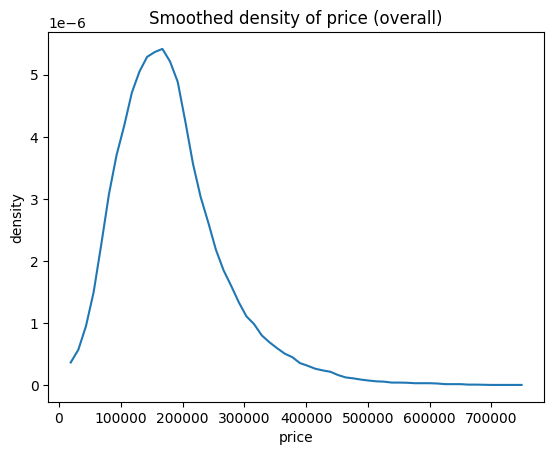


Q7(2) price describe by Bldg.Type:
             count           mean           std      min       25%       50%  \
Bldg.Type                                                                     
1Fam       2425.0  184812.041237  82821.802329  12789.0  130000.0  165000.0   
2fmCon       62.0  125581.709677  31089.239840  55000.0  106562.5  122250.0   
Duplex      109.0  139808.935780  39498.973534  61500.0  118858.0  136905.0   
Twnhs       101.0  135934.059406  41938.931130  73000.0  100500.0  130000.0   
TwnhsE      233.0  192311.914163  66191.738021  71000.0  145000.0  180000.0   

                75%       max  
Bldg.Type                      
1Fam       220000.0  755000.0  
2fmCon     140000.0  228950.0  
Duplex     153337.0  269500.0  
Twnhs      170000.0  280750.0  
TwnhsE     222000.0  392500.0  


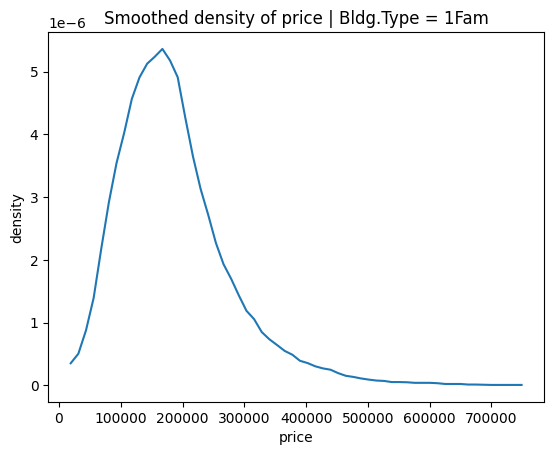

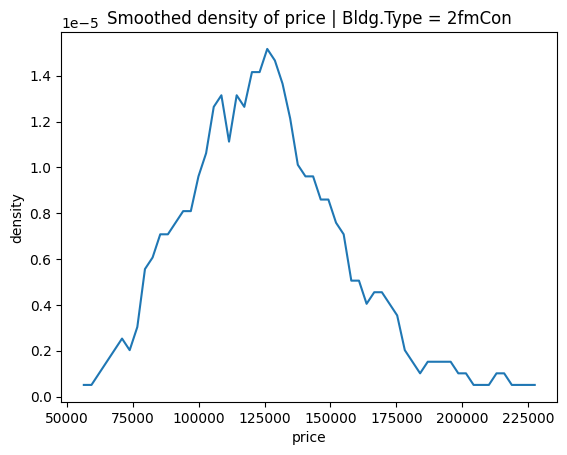

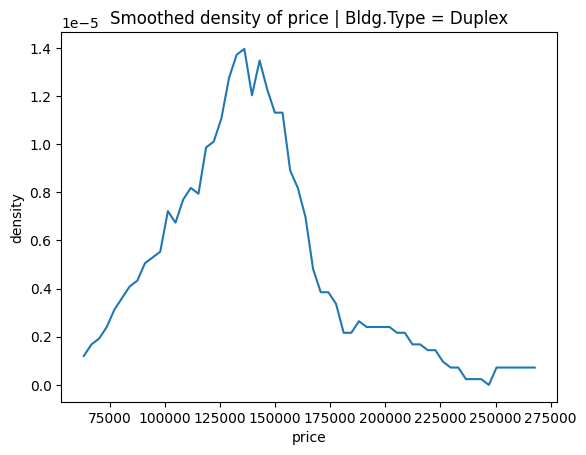

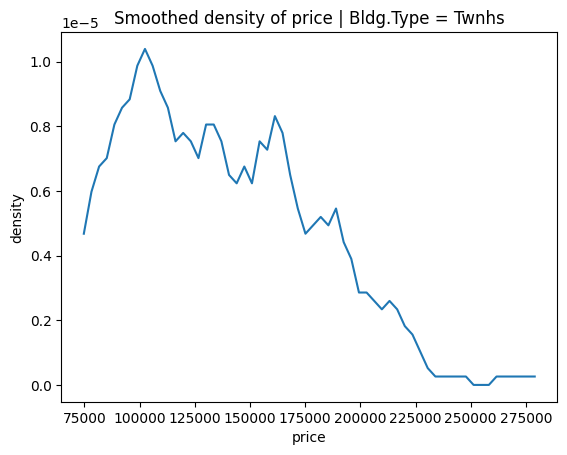

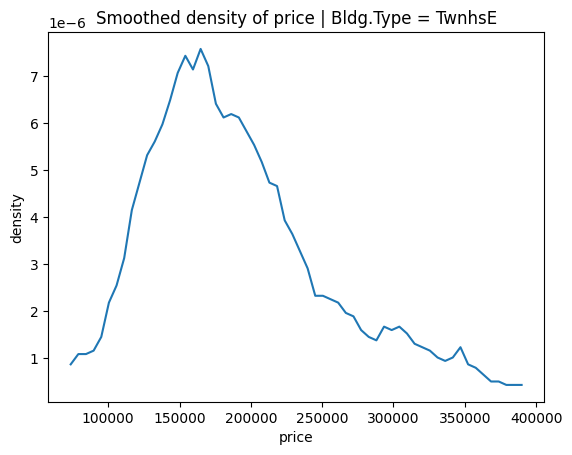


Q7(2) Most expensive on average (mean price):
 Bldg.Type
TwnhsE    192311.914163
1Fam      184812.041237
Duplex    139808.935780
Twnhs     135934.059406
2fmCon    125581.709677
Name: price, dtype: float64

Q7(2) Highest variance in price:
 Bldg.Type
1Fam      6.859451e+09
TwnhsE    4.381346e+09
Twnhs     1.758874e+09
Duplex    1.560169e+09
2fmCon    9.665408e+08
Name: price, dtype: float64


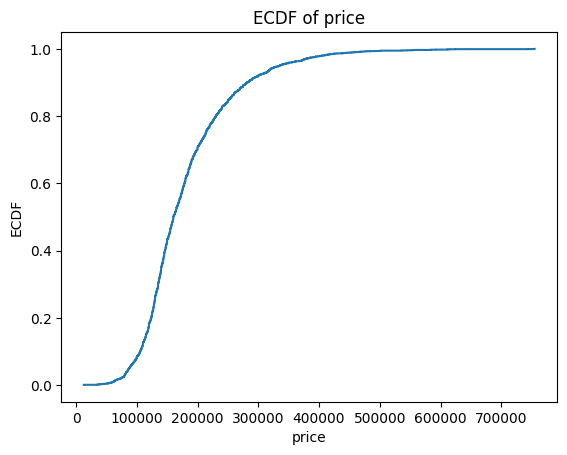


Q7(3) 5-number summary:
 min        12789.0
q1        129500.0
median    160000.0
q3        213500.0
max       755000.0
Name: price, dtype: float64


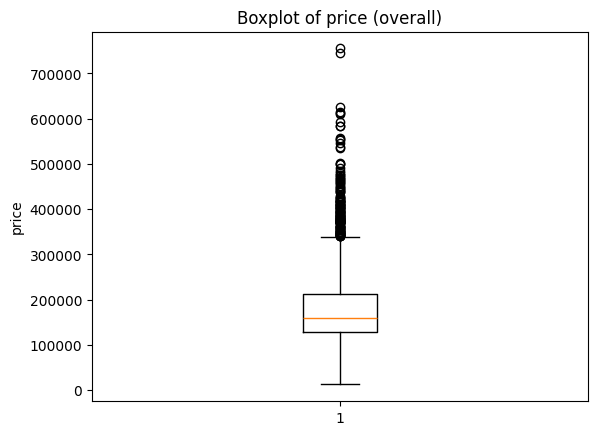

/var/folders/tm/rcl9c7rx5_sd30ypm6jzq3g40000gn/T/ipykernel_40503/3698395076.py:77: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_by_type, labels=types, vert=True)


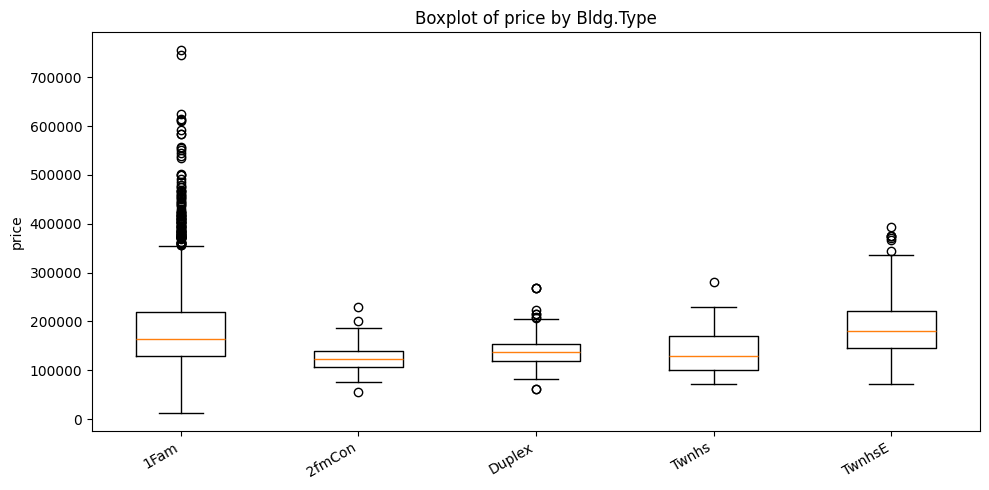


Q7(5) Outlier fences: 3500.0 339500.0
Q7(5) Outlier count: 137
Q7(5) Outlier proportion: 0.04675767918088737

Q7(6) Winsorization caps (1% and 99%): 61756.07 456666.3700000001

Q7(6) price_winsor describe:
 count      2930.000000
mean     180091.154334
std       75842.579174
min       61756.070000
25%      129500.000000
50%      160000.000000
75%      213500.000000
max      456666.370000
Name: price_winsor, dtype: float64


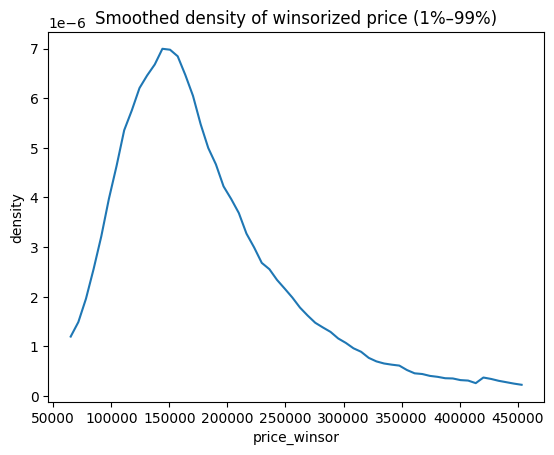

In [6]:
df = pd.read_csv("/Users/david/Downloads/analytics/ml_container/data/ames_prices.csv", encoding="latin1")

df["price"] = pd.to_numeric(df["price"], errors="coerce")
df["Bldg.Type"] = df["Bldg.Type"].astype(str).str.strip()

df = df.dropna(subset=["price", "Bldg.Type"]).copy()

print("Q7(1) shape (rows, cols):", df.shape)
print("\nQ7(1) head():\n", df.head())

def smooth_density(x, bins=60, smooth_window=11):
    x = pd.to_numeric(pd.Series(x), errors="coerce").dropna().to_numpy()
    if len(x) == 0:
        return None, None
    counts, edges = np.histogram(x, bins=bins, density=True)
    centers = (edges[:-1] + edges[1:]) / 2
    w = max(3, smooth_window)
    if w % 2 == 0:
        w += 1
    kernel = np.ones(w) / w
    smooth = np.convolve(counts, kernel, mode="same")
    return centers, smooth

print("\nQ7(2) price describe (overall):\n", df["price"].describe())

x_all, y_all = smooth_density(df["price"])
plt.figure()
plt.plot(x_all, y_all)
plt.title("Smoothed density of price (overall)")
plt.xlabel("price")
plt.ylabel("density")
plt.show()

print("\nQ7(2) price describe by Bldg.Type:\n", df.groupby("Bldg.Type")["price"].describe())

for t in sorted(df["Bldg.Type"].unique()):
    sub = df[df["Bldg.Type"] == t]
    x_t, y_t = smooth_density(sub["price"])
    plt.figure()
    plt.plot(x_t, y_t)
    plt.title(f"Smoothed density of price | Bldg.Type = {t}")
    plt.xlabel("price")
    plt.ylabel("density")
    plt.show()

avg_by_type = df.groupby("Bldg.Type")["price"].mean().sort_values(ascending=False)
var_by_type = df.groupby("Bldg.Type")["price"].var().sort_values(ascending=False)

print("\nQ7(2) Most expensive on average (mean price):\n", avg_by_type)
print("\nQ7(2) Highest variance in price:\n", var_by_type)

prices = df["price"].dropna().to_numpy()
prices_sorted = np.sort(prices)
ecdf_y = np.arange(1, len(prices_sorted) + 1) / len(prices_sorted)

plt.figure()
plt.step(prices_sorted, ecdf_y, where="post")
plt.title("ECDF of price")
plt.xlabel("price")
plt.ylabel("ECDF")
plt.show()

five_num = df["price"].quantile([0, 0.25, 0.5, 0.75, 1.0])
five_num.index = ["min", "q1", "median", "q3", "max"]
print("\nQ7(3) 5-number summary:\n", five_num)

plt.figure()
plt.boxplot(df["price"].dropna(), vert=True)
plt.title("Boxplot of price (overall)")
plt.ylabel("price")
plt.show()

types = sorted(df["Bldg.Type"].unique())
data_by_type = [df.loc[df["Bldg.Type"] == t, "price"].dropna().to_numpy() for t in types]

plt.figure(figsize=(10, 5))
plt.boxplot(data_by_type, labels=types, vert=True)
plt.title("Boxplot of price by Bldg.Type")
plt.ylabel("price")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

q1 = df["price"].quantile(0.25)
q3 = df["price"].quantile(0.75)
iqr = q3 - q1
lower_fence = q1 - 1.5 * iqr
upper_fence = q3 + 1.5 * iqr

df["outlier"] = ((df["price"] < lower_fence) | (df["price"] > upper_fence)).astype(int)

print("\nQ7(5) Outlier fences:", lower_fence, upper_fence)
print("Q7(5) Outlier count:", int(df["outlier"].sum()))
print("Q7(5) Outlier proportion:", df["outlier"].mean())

lo = df["price"].quantile(0.01)
hi = df["price"].quantile(0.99)
df["price_winsor"] = df["price"].clip(lower=lo, upper=hi)

print("\nQ7(6) Winsorization caps (1% and 99%):", lo, hi)
print("\nQ7(6) price_winsor describe:\n", df["price_winsor"].describe())

x_w, y_w = smooth_density(df["price_winsor"])
plt.figure()
plt.plot(x_w, y_w)
plt.title("Smoothed density of winsorized price (1%–99%)")
plt.xlabel("price_winsor")
plt.ylabel("density")
plt.show()